# Circuit for Shor’s algorithm using 2n+3 qubits
In this notebook, Shor's algorithm is efficiently implemented using the method described in [arXiv:quant-ph/0205095](https://arxiv.org/pdf/quant-ph/0205095.pdf) by Stéphane Beauregard. Qiskit textbook's chapter on Shor's algorithm ([3.7](https://qiskit.org/textbook/ch-algorithms/shor.html)) is also used as a reference. 

## Imports
First we import everything we are going to use throghout the notebook. Some of these are just for aesthetic or visualization purposes and can be removd if only interested in functionaility.

In [16]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, SwapGate
from qiskit.extensions import UnitaryGate
from random import randrange
from sympy import Matrix
import numpy as np
from fractions import Fraction
import pandas as pd

## Classical part
We also need to define some classical functions that will help us later on. The first function simply applies [Euclid's algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm) to get the greatest common divisor of two numbers.

In [37]:
def euclids(a, b):
    """
    Given two integers a and b, compute gcd(a, b) using Euclid's algorithm.
    
    Parameters:
    -----------
    a: int
        First integer for Euclid's algorithm
    b: int
        Second integer for Euclid's algorithm
        
    Returns:
    --------
    b: int
        Returns gcd(a, b) stored on input b
    """
    while True:
        r = a % b
        if not r:
            break
        a = b
        b = r
    return b

The next function computes $a^{2^j} \: \text{mod} \: N$ efficiently using repeated squaring.

In [38]:
def a2jmodN(a, j, N):
    """
    Compute a^{2^j} (mod N) by repeated squaring
    
    Parameters:
    -----------
    a: int
        Value for a
    j: int
        Value for j
    N: int
        Value for N
        
    Returns:
    --------
    a: int
        a^{2^j} (mod N)
    """
    for i in range(j):
        a = np.mod(a**2, N)
    return a

The function below computes the modular inverse of $a \: \text{mod} \: N$ using the procedure described [here](https://www.khanacademy.org/computing/computer-science/cryptography/modarithmetic/a/modular-inverses).

In [44]:
def mod_inv(a, N):
    for i in range(N):
        if (a * i) % N == 1: return i
    raise Exception(f"Modular inverse of {a} mod {N} doesn't exist")

## Quantum part
The following functions assemble the different parts of the circuit. These are given in the same order they appear on the reference paper. 

### Set Initial State
The following function sets a register of $n$ qubits into the value specified by `val_a` in binary. The following convenction is used: $q_0$ is the top qubit of the circuit and corresponds to $2^0$, $q_1$ to $2^1$ and so on.

In [17]:
def set_initial(n, val_a):
    """
    Construct gate to set initial state of register with size n to val_a.
    For example n=4 with val_a=5 will apply X gates on qubits 0 and 2. 
    
    Parameters:
    -----------
    n: int
        Size of register we want to initialize
    val_a: int
        Value to which we want to initialize 
        
    Returns:
    --------
    init_gate: Gate
        Constructed gate
        
    """
    if ((2**n) - 1) < val_a:
        raise Exception(f'Cannot initialize {val_a} into given register, there are no sufficient qubits')
        
    reg_a = QuantumRegister(n)
    gate  = QuantumCircuit(reg_a)
    
    bin_a = "{0:b}".format(val_a).zfill(n)
    for idx, i in enumerate(bin_a[::-1]):
        if i == '1': gate.x(idx)

    init_gate = gate.to_gate(label=f'Init {val_a}')
    return init_gate

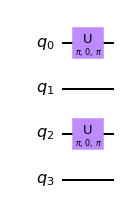

In [18]:
qc = QuantumCircuit(4)

init = set_initial(4, 5)
qc.append(init, [0,1,2,3])
qc = transpile(qc, basis_gates=['u', 'cx'])
qc.draw('mpl')

In the circuit above, the register is initialized to 5. In binary, this is 0101. Therefore, an $X$ gate ($U(\pi, 0, \pi)$) is applied to qubits 0 and 2 ($2^0+2^2=5$).

### Adder and Subtracter
The following classicaly computes an addition transform, converts it to a Qiskit unitary gate, and applies it to the given register. The register to which it is applied should contain a number encoded in the Fourier basis. Similarly, the result will be stored in the same register also in the Fourier basis.

The normal circuit for addition consists of controlled phase gates, the control being qubits from register with the number in the computational basis that we want to add to the output register. In our case, since we know beforehand the value that we want to add (and we know it is not in a superposition), we can clasically compute which gates would be applied and transform the whole circuit into a single unitary gate. This also eliminates the need for two registers, we just apply the unitary to the output register.

The subtracter is simply the inverse of the adder gate. We just call the `.inverse()` function on the adder gate and we get the subtracter gate.

In [19]:
def adder(n, val_a, dag=False):
    """
    Construct gate to add val_a into register b in the Fourier basis.
    Register b must contain the number on the Fourier basis already.
    The subtracter gate gives us b - a if b ≥ a or 2^{n+1}−(a−b) if b < a. It is obtained by inversing the adder.
    
    Parameters:
    -----------
    n: QuantumRegister
        Size of register b
    val_a: int
        Value to which register a will be initialized
    dag: Boolean
        If set to true, the dagger of the adder gate (the subtracter) is appended
    
    Returns:
    --------
    adder_gate: Gate
        Constructed gate
    """
    
    bin_a = "{0:b}".format(val_a).zfill(n)
    phase = lambda lam: np.array([[1, 0], [0, np.exp(1j * lam)]])
    identity = np.array([[1, 0], [0, 1]])
    arr_gates = []
    
    for i in range(n):
        qubit_gate = identity
        for j in range(i, n):
            if bin_a[j] == '1':
                qubit_gate = phase(np.pi / (2 ** (j - i))) @ qubit_gate
        arr_gates.append(qubit_gate)

    unitary = arr_gates[0]
    for i in range(1, len(arr_gates)):
        unitary = np.kron(arr_gates[i], unitary)
    
    adder_gate = UnitaryGate(unitary)
    adder_gate.label = f"Add {val_a}"
    if dag == True:
        adder_gate = adder_gate.inverse()
        adder_gate.label = f"Subtract {val_a}"
        
    return adder_gate

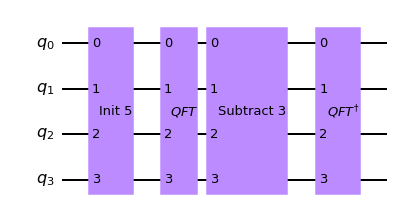

{'0010': 1.000000000000002}

In [49]:
b = QuantumRegister(4, name='q')
q = QuantumCircuit(b)

add_1 = 5
add_2 = 3

init = set_initial(b.size, add_1)
q.append(init, b[:])

qft = QFT(4, name="$QFT$")
q.append(qft, b[:])

add = adder(4, add_2, dag=True)
q.append(add, b[:])

qft_i = QFT(4, inverse=True, name="$QFT^\dag$")
q.append(qft_i, b[:])

display(q.draw('mpl'))

backend = Aer.get_backend('statevector_simulator')
q = transpile(q, basis_gates=['cx', 'u'])
result = backend.run(q).result()
counts = result.get_counts()
counts

The circuit above initializes the register to 5, then applies a $QFT$ so that it is in the Fourier basis before we apply the subtracter gate. Then, the subtracter gate subtracts 3 from the register and finally we apply the inverse $QFT$ to go from the Fourier basis to the computational basis. As you can see, the result is always 0010 which equals 2. Therefore, our adder/subtracter gate works.

### Modular Adder
The modular adder gate computes $(a + b) \: \text{mod} \: N$ and stores the value in the Fourier basis on the output register (`reg_b`). As with the adder gate, the output register already needs to contain $b$ in the Fourier basis before we apply this gate to it. We make use of two other registers: `reg_c` that acts as a control, i.e., if both qubits in `reg_c` are set to $|1\rangle$, then the gate takes effect; and `aux` that helps check for overflow in the addition/subtraction steps. It's important to note that the `aux` qubit starts at the state $|0\rangle$ and ends up at the same state even if it is modified during computation. This is important because if the computation is not clean, the whole algorithm may not work.

In [25]:
def mod_adder(n, val_a, val_N):
    """
    Construct gate to compute a + b mod N in the Fourier basis. 
    Register b must contain the number on the Fourier basis already, and the answer will be in this register.
    
    Parameters:
    -----------
    n: QuantumRegister
        Size of register b
    val_a: int
        Value to add to register
    val_N: int
        We take mod of a + b respect to this value
        
    Returns:
    --------
    mod_adder_gate: Gate
        Constructed gate
        
    """ 
    
    reg_c = QuantumRegister(2)
    reg_b = QuantumRegister(n)
    aux   = QuantumRegister(1)
    gate  = QuantumCircuit(reg_c, reg_b, aux)
    
    qft     = QFT(n, name="$QFT$").to_gate()
    qft_inv = QFT(n, inverse=True, name="$QFT^\dag$").to_gate()
    
    gate.append(adder(n, val_a).control(2), reg_c[:] + reg_b[:])
    gate.append(adder(n, val_N, dag=True), reg_b[:])
    
    gate.append(qft_inv, reg_b[:])
    gate.cx(reg_b[-1], aux[0])
    gate.append(qft, reg_b[:])
    
    gate.append(adder(n, val_N).control(1), aux[:] + reg_b[:])
    gate.append(adder(n, val_a, dag=True).control(2), reg_c[:] + reg_b[:])
    
    gate.append(qft_inv, reg_b[:])
    gate.x(reg_b[-1])
    gate.cx(reg_b[-1], aux[0])
    gate.x(reg_b[-1])
    gate.append(qft, reg_b[:])
    
    gate.append(adder(n, val_a).control(2), reg_c[:] + reg_b[:])
    mod_adder_gate = gate.to_gate(label=f"Add {val_a} mod {val_N}")
    
    return mod_adder_gate

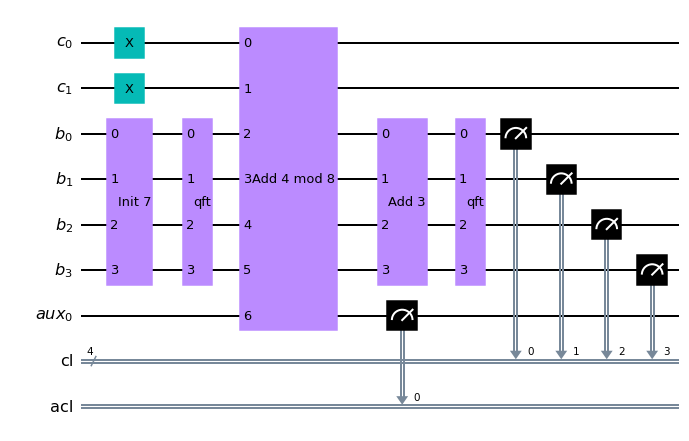

{'0 0110': 1024}

In [26]:
c = QuantumRegister(2, name='c')
b = QuantumRegister(4, name='b')
aux = QuantumRegister(1, name='aux')
clas = ClassicalRegister(4, name='cl')
aux_clas = ClassicalRegister(1, name='acl')
qc = QuantumCircuit(c,b,aux,clas,aux_clas)

val_a = 4
val_b = 7 # b < 2 ** (n - 1)
val_N = 8

init = set_initial(b.size, val_b) 
qc.append(init, b[:])

qft = QFT(4)
qc.append(qft, b[:])

qc.x(c)

mod_add = mod_adder(b.size, val_a, val_N)
qc.append(mod_add, c[:] + b[:] + aux[:])

add = adder(b.size, 3)
qc.append(add, b[:])

qft_1 = QFT(4, inverse=True)
qc.append(qft_1, b[:])

qc.measure(b,clas)
qc.measure(aux,aux_clas)

display(qc.draw('mpl'))

backend = Aer.get_backend('qasm_simulator')
qc = transpile(qc, basis_gates=['u', 'cx'])
result = backend.run(qc).result()
counts = result.get_counts()
counts

In the circuit above, we apply a combination of the recently defined gate and the adder gate; we do this to make sure they work together nicely. Note that the qubits in the control register are set to $|11\rangle$ in the beggining, this is to make sure that the modular adder gate is applied. The computation we are doing is basically the following:

$$
((7 + 4) \: \text{mod} \: 8) + 3 = (11 \: \text{mod} \: 8) + 3 = 3 + 3 = 6
$$ 

As you can see, this is the result we get when measuring `reg_b`, i.e., 0110. We also measure the `aux` qubit to make sure it gets set back to $|0\rangle$ as intended, and it does. Therefore, we are confident the gates we've constructed until now work correctly.

### Controlled Multiplier
The controlled multiplier gate computes $(b + a\cdot x) \: \text{mod} \: N$ if the control qubit is set to $|1\rangle$, and leaves the output register (`reg_b`) unchanged if the control is set to $|0\rangle$. We use the control qubits from the previous gate in this one, but this time one is always in `reg_c` and the other goes through all the qubits in `reg_x`. Therefore, if the qubit in `reg_c` is set to $|0\rangle$, the gate has no effect.

The inverse of this circuit can be taken as we did with the adder gate and it computes $(b - a\cdot x) \: \text{mod} \: N$.

In [27]:
def ctrl_mult(n, val_a, val_N, dag=False):
    """
    Construct gate that computes (b + ax) mod N if control qubit is set to 1.
    The gate transforms the value in register b to the Fourier basis within it.
    
    Parameters:
    -----------
    n: QuantumRegister
        Size of registers b and x
    val_a: int
        Value to multiply by x
    val_N: int
        We take mod of (b + ax) mod N respect to this value
    dag: bool
        If set to true, the dagger of the adder gate (the subtracter) is appended
        
    Returns:
    --------
    ctrl_mult_gate: Gate
        Constructed gate
        
    """
    
    reg_c = QuantumRegister(1)
    reg_x = QuantumRegister(n)
    reg_b = QuantumRegister(n)
    aux   = QuantumRegister(1)
    gate  = QuantumCircuit(reg_c, reg_x, reg_b, aux)
    
    qft     = QFT(n, name="$QFT$").to_gate()
    qft_inv = QFT(n, inverse=True, name="$QFT^\dag$").to_gate()
    
    gate.append(qft, reg_b[:])
    
    for i in range(n):
        gate.append(mod_adder(n, (2**i) * val_a, val_N), reg_c[:] + [reg_x[:][i]] + reg_b[:] + aux[:])
        
    gate.append(qft_inv, reg_b[:])
    ctrl_mult_gate = gate.to_gate(label=f"Mult {val_a} mod {val_N}")
    if dag == True:
        ctrl_mult_gate = ctrl_mult_gate.inverse()
        ctrl_mult_gate.label = f"Mult {val_a} mod {val_N} inv"
    
    return ctrl_mult_gate

By its own, and without ensuring that the parameters that go into it are valid, this gate doesn't make much sense. Its output is not the correct one and the `aux` qubit isn't set back to $|0\rangle$ if you are not careful with the parameters that you put into it. For this reason, it doesn't make much sense to show it by itself. But you'll see how it works with other gates to make a bigger—and functional—circuit shortly.

### Controlled $U_a$
The Controlled $U_a$ gate is the one directly used in Shor's algorithm. It computes $(a\cdot x) \: \text{mod} \: N$, the operation needed for the algorithm. It is fairly simple, `reb_b` (as we have refered to it previously but it is refered to as `reg_y`) in the following function) is set to $|0\rangle^{\otimes n}$ and then we apply the above gate to compute $(0 + a \cdot x) \: \text{mod} \: N = (a \cdot x) \: \text{mod} \: N$. Then, we swap registers `reg_x` and `reg_y` to get the result into `reg_x`. Finally, the inverse of the above gate with $a$ being the modular inverse of $a \: \text{mod} \: N$ is applied to reset `reg_y`. This is important because `reg_y` needs to be in the $|0\rangle^{\otimes n}$ state for further computation in Shor's algorithm.

In [46]:
def u_a(n, val_a, val_N):
    reg_c = QuantumRegister(1)
    reg_x = QuantumRegister(n)
    reg_y = QuantumRegister(n)
    aux   = QuantumRegister(1)
    
    gate  = QuantumCircuit(reg_c, reg_x, reg_y, aux)
    
    gate.append(ctrl_mult(n, val_a, val_N), reg_c[:] + reg_x[:] + reg_y[:] + aux[:])
    
    temp_qc = QuantumCircuit(2*n)
    temp_qc.swap([i for i in range(n)], [i for i in range(n, 2*n)])
    cswap = temp_qc.to_gate(label='CSWAP').control(1)
    gate.append(cswap, reg_c[:] + reg_x[:] + reg_y[:])
    
    gate.append(ctrl_mult(n, mod_inv(val_a, val_N), val_N, dag=True), reg_c[:] + reg_x[:] + reg_y[:] + aux[:])
    u_a_gate = gate.to_gate(label=f"$U_{val_a}$")
    
    return u_a_gate         

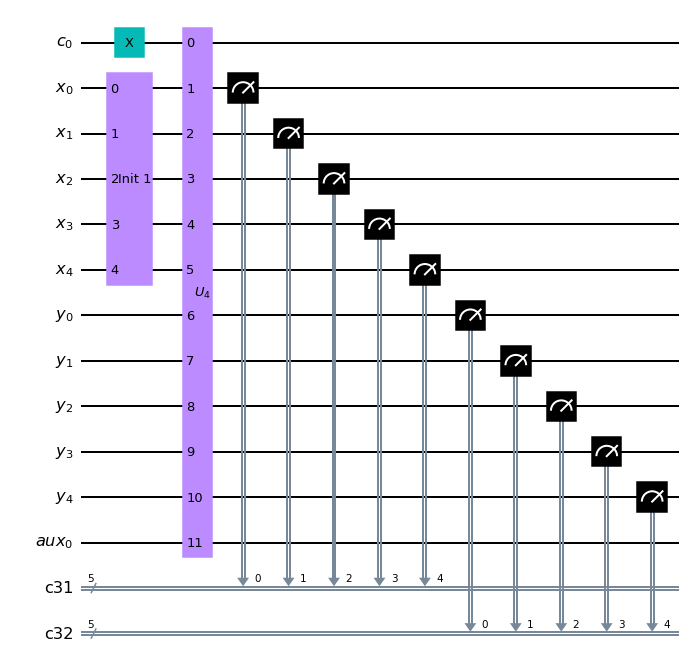

Expected:  4
{'00000 00100': 1024}


In [48]:
val_a = 4
val_n = 7
val_x = 1

c = QuantumRegister(1, name='c')
x = QuantumRegister(5, name='x')
y = QuantumRegister(5, name='y')
aux = QuantumRegister(1, name='aux')
clas_0 = ClassicalRegister(5)
clas_1 = ClassicalRegister(5)
qc = QuantumCircuit(c, x, y, aux, clas_0, clas_1)

qc.x(c)

init_x = set_initial(5, val_x)
qc.append(init_x, x[:])

u = u_a(5, val_a, val_n)
qc.append(u, c[:] + x[:] + y[:] + aux[:])

qc.measure(x, clas_0)
qc.measure(y, clas_1)

display(qc.draw('mpl'))

print("Expected: ", (val_a * val_x) % val_n)

backend = Aer.get_backend('qasm_simulator')
qc = transpile(qc, basis_gates=['u', 'cx'])
result = backend.run(qc).result()
counts = result.get_counts()
print(counts)

As you can see above, we get the desired result of 4 in `reg_x` and 0 in `reg_y`. Therefore, our controlled $U_a$ gate indeed works and can be used in Shor's algorithm.

### Circuit to Factorize 15
As an example, we are going to factorize 15 using the controlled $U_a$ we built throghout the notebook. We follow the construction showed in Figure 1 of the reference paper. We also use as reference—mainly for the classical postprocessing—the construction shown in the Qiskit textbook ([3.7.3](https://qiskit.org/textbook/ch-algorithms/shor.html#3.-Qiskit-Implementation)) that also factorizes 15.  

First we get the number of qubits we are going to need. We do this by getting the binary representation of 15. We also set a suitable value for $a$, which in this case will be 2.

In [50]:
n = len("{0:b}".format(15))
a = 2
N = 15

Then, we set up the circuit as shown in Figure 1 of the paper. Notice that here the $X$ gate is applied to the first qubit of `reg_b` instead of the last one as shown in the Qiskit textbook. This is because we are regarding this qubit as corresponding to $2^0$, and therefore setting it to $|1\rangle$ makes the whole register correspond to the 1 (decimal) state. Qiskit's convention differs, but the results we get are **very** similar.

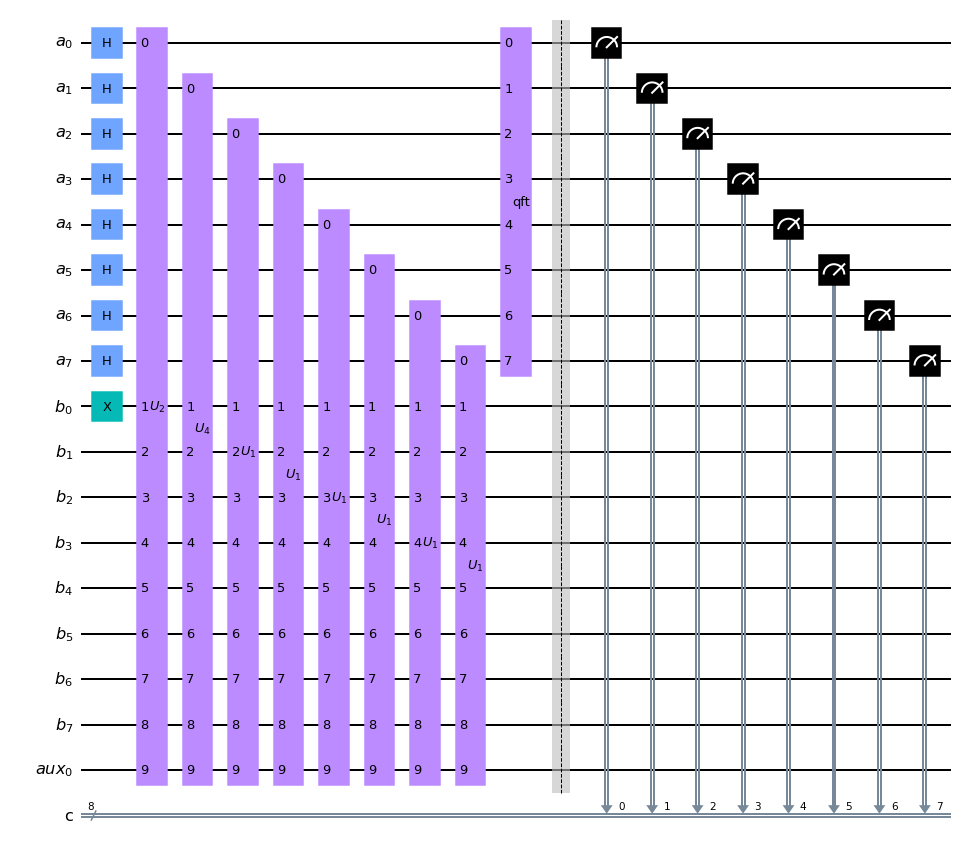

In [110]:
reg_a = QuantumRegister(2 * n, name='a')
reg_b = QuantumRegister(2 * n, name='b')
aux   = QuantumRegister(1, name='aux')
clas  = ClassicalRegister(2 * n, name='c')
qc    = QuantumCircuit(reg_a, reg_b, aux, clas)

qc.h(reg_a)
qc.x(reg_b[0])

qc.append(u_a(n, a2jmodN(a, 0, N), N), [reg_a[:][0]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 1, N), N), [reg_a[:][1]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 2, N), N), [reg_a[:][2]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 3, N), N), [reg_a[:][3]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 4, N), N), [reg_a[:][4]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 5, N), N), [reg_a[:][5]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 6, N), N), [reg_a[:][6]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 7, N), N), [reg_a[:][7]] + reg_b[:] + aux[:])

qc.append(QFT(2 * n, inverse=True), reg_a[:])

qc.barrier()

qc.measure(reg_a, clas)

qc.draw('mpl')

Once the circuit is constructed, we run it with the `aer_simulator`. In the histogram, it is hard to see which results are the most common one, but you can see that there are four of them. In fact, these 4 are the same 4 that you get from running the circuit from the Qiskit textbook.

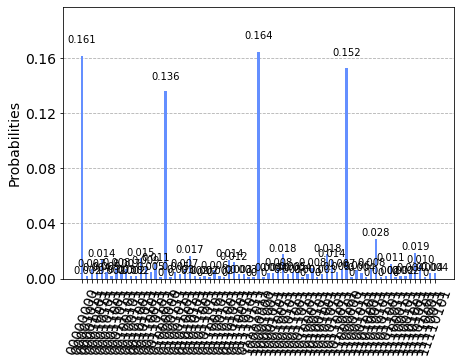

In [111]:
aer_sim = Aer.get_backend('aer_simulator')
qc = transpile(qc, aer_sim)
results = aer_sim.run(qc).result()
counts = results.get_counts()
plot_histogram(counts)

To get the values of the most common measurements, I just select those that had over 50 counts out of the 1024 shots. This is an arbitrary choice that helps us get rid of those measurements that come from noise. And you can see that the four remaining measurements are the exact same from the Qiskit textbook.

In [114]:
filtered_counts = []
for count in counts:
    total += counts[count]
    if counts[count] > 50:
        filtered_counts.append(count)
filtered_counts

['01000000', '00000000', '10000000', '11000000']

The following two cells use code from the Qiskit textbook to get the phases corresponding to our most common measurements and then their guess for $r$ (period we are looking for).

In [118]:
rows, measured_phases = [], []
for output in filtered_counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**(2 * n))  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**(2 * n)} = {phase:.2f}"])

# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [119]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
    r_guesses.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.75      3/4            4


Since the most common guess for $r$ is 4, we use this to find the factors for 15 using the normal postprocessing of Shor's algorithm. (You can read about this in my notebook about Shor's algorithm [here](https://github.com/epelaaez/QuantumLibrary/blob/master/algorithms/Prime%20Factorization.ipynb)).

In [120]:
r = 4
guesses = [euclids(a**(r//2)-1, N), euclids(a**(r//2)+1, N)]
print(guesses)

[3, 5]


And we get 3 and 5, which are the prime factors of 15! Therefore, we can conclude that our circuit construction works. However, this doesn't use $2n+3$ as stated in the paper. This is because we've only used the gates from the paper but not the final construction they give. In order to use only $2n+3$ qubits, we need to construct a circuit that looks like Figure 8 in the reference paper. This is:

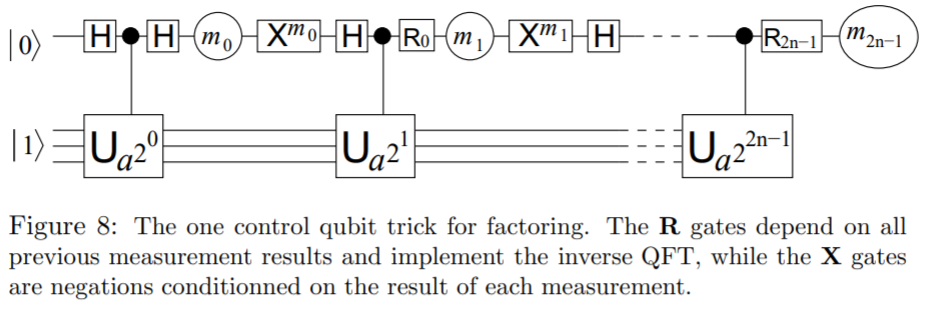